Построить классификатор, который "угадывает" персонажа по его фразе.

In [46]:
import nltk
import itertools
import re
import numpy as np
import pandas as pd
from nltk import RegexpTokenizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import word_tokenize, wordpunct_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [33]:
# чтобы посмотреть на таблицу
df = pd.read_csv('season-4.csv')
df.head()

,Season,Episode,Character,Line
0,4,1,Butters,Wuh-okay! You guys ready up there!?\n
1,4,1,Sledders,Ready!\n
2,4,1,Butters,On your marks! Get set! Uh-go! \n
3,4,1,Stan,We win again! \n
4,4,1,Token,That's not fair! Cartman's ass is so fat he ma...


Мне стыдно признаться, но я никогда не смотрела South Park, поэтому я не знаю, что характеризует каждого героя. Чтобы мне было легче, я лучше сокращу датасет до 5 героев.

In [34]:
sp = pd.read_csv('season-4.csv', sep=',')
Characters = sp.groupby(['Character']).size().sort_values(ascending=False)
Characters

Character
Cartman               801
Stan                  608
Kyle                  501
Mr. Garrison          135
Kenny                 129
Timmy                 123
Satan                 111
Chef                  103
Pip                    94
Butters                87
Randy                  81
Chris                  69
Wendy                  62
Liane                  62
Ms. Choksondik         59
Sharon                 57
Saddam                 57
Sheila                 51
Mark                   48
Man                    48
Mr. Hankey             45
Mr. Mackey             44
Kids                   41
Sister Anne            37
Principal Victoria     36
Jimbo                  33
Romper Stomper         33
Ms. Havisham           32
Mrs. McCormick         32
Estella                32
                     ... 
Demon                   1
Saddam/Chris            1
Damned Soul             1
Gene Siskel             1
Protester 5             1
Other Students          1
Paramedic               1
Ot

Вот, возьму как раз тех, у кого кол-во реплик от 100 до 135.

In [35]:
Charecters_SP = Characters[:5]
SP_Charecters_SP = sp.loc[(sp['Character'] == 'Mr. Garrison') | (sp['Character'] == 'Kenny') |
                  (sp['Character'] == 'Timmy') | (sp['Character'] == 'Satan') | (sp['Character'] == 'Chef')
            ]
Charecters_SP
SP_Charecters_SP

,Season,Episode,Character,Line
88,4,1,Kenny,(What the fuck for?!)\n
90,4,1,Kenny,(Mexico?! Why the heck do I have to take you a...
92,4,1,Kenny,(Hey!)\n
94,4,1,Kenny,(Yes)\n
99,4,1,Kenny,(Why don'tcha keep your head down?!) \n
152,4,1,Kenny,(Huh? Uh.) (AAAAAA!) (Ufff!) (Ugh!)\n
387,4,2,Kenny,(Nuh-uh.)\n
389,4,2,Kenny,(No way!)\n
391,4,2,Kenny,(No I don't! Thank you.)\n
395,4,2,Timmy,Timmiihh!\n


По поводу ненормативной лексики, не знаю, стоит ли её сокращать, ведь по её количеству я понимаю 1) это очень частотно, 2) возможно, это концепция сериала.

In [36]:
# Токенизируем без учёта знаков
def tokenize(text):    
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)

stopwords = stopwords.words('english')

#  И делим всю нашу выборку в соотношении 20:80
text_train, text_test, character_train, character_test = train_test_split(SP_Charecters_SP['Line'], SP_Charecters_SP['Character'], test_size=0.2)

In [37]:
# Векторизуем и Байнс
res = Pipeline([('bow', CountVectorizer(analyzer=tokenize, stop_words=stopwords)),
                ('classifier', MultinomialNB())])
res.fit(text_train, character_train)
character_pred = res.predict(text_test)
print(classification_report(character_test, character_pred))

              precision    recall  f1-score   support

        Chef       0.62      0.43      0.51        23
       Kenny       0.62      0.37      0.47        27
Mr. Garrison       0.43      0.62      0.51        29
       Satan       0.53      0.80      0.64        20
       Timmy       1.00      0.77      0.87        22

 avg / total       0.63      0.59      0.59       121



In [38]:
# Регрессия
res = Pipeline([('bow', CountVectorizer(analyzer=tokenize, stop_words=stopwords)),
                ('classifier', LogisticRegression())])
res.fit(text_train, character_train)
character_pred = res.predict(text_test)
print(classification_report(character_test, character_pred))

              precision    recall  f1-score   support

        Chef       0.56      0.43      0.49        23
       Kenny       0.50      0.78      0.61        27
Mr. Garrison       0.56      0.48      0.52        29
       Satan       0.88      0.70      0.78        20
       Timmy       0.90      0.82      0.86        22

 avg / total       0.66      0.64      0.64       121



In [39]:
# Рандом форест
res = Pipeline([('bow', CountVectorizer(analyzer=tokenize, stop_words=stopwords)),
                ('classifier', RandomForestClassifier())])
res.fit(text_train, character_train)
character_pred = res.predict(text_test)
print(classification_report(character_test, character_pred))

              precision    recall  f1-score   support

        Chef       0.58      0.61      0.60        23
       Kenny       0.52      0.44      0.48        27
Mr. Garrison       0.46      0.21      0.29        29
       Satan       0.50      0.60      0.55        20
       Timmy       0.59      1.00      0.75        22

 avg / total       0.53      0.55      0.51       121



Лучше всех реплики определяет байес-модель, хуже всех - рандом форест. Во всех случаях лучше всего определился Timmy, скорее всего, его реплики были однотипны. Я рассуждаю по precision

In [58]:
# Из интернета
cm = confusion_matrix(character_test, character_pred)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [59]:
# Скелет из интернета
# Compute confusion matrix
cnf_matrix = confusion_matrix(character_test, res.predict(text_test))
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[14  2  4  2  1]
 [ 1 12  1  5  8]
 [ 8  5  6  5  5]
 [ 1  4  2 12  1]
 [ 0  0  0  0 22]]


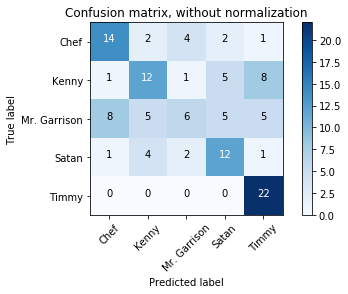

In [60]:
# Скелет из интернета
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=res.classes_,
                      title='Confusion matrix, without normalization')

plt.show()

Normalized confusion matrix
[[ 0.61  0.09  0.17  0.09  0.04]
 [ 0.04  0.44  0.04  0.19  0.3 ]
 [ 0.28  0.17  0.21  0.17  0.17]
 [ 0.05  0.2   0.1   0.6   0.05]
 [ 0.    0.    0.    0.    1.  ]]


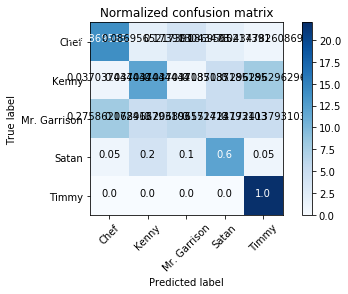

In [61]:
# Скелет из интернета
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=res.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Всё равно лучше всех реплики определяет байес-модель, но логистическая регрессия  хуже всех - рандом форест. Во всех случаях лучше всего определился Timmy, скорее всего, его реплики были однотипны. Я рассуждаю по precision